In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

# Rossmann

The key thing here is that we're trying to on a particular date for a particular store ID, we want to predict the number of sales. Sales is the dependent variable.

## Data preparation

To create the feature-engineered `train_clean` and `test_clean` from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```



If you run `add_datepart` and pass it a date, it'll add all of these columns to your data set for you:
- Day of week, year, month, week of year, day of month, day of week, day of year, and then a bunch of booleans is it at the month start/end, quarter year start/end, elapsed time since 1970, so forth.



In [3]:
path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [4]:
pd.set_option('display.max_rows', None) # display all rows
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [5]:
pd.set_option('display.max_rows', 10) # reset max no. of rows for display to 10

In [6]:
n = len(train_df); n

844338

## Experimenting with a sample

TY - It's a good idea to try the entire process of learning on subset of the data first. From preprocessing to learning. This way will take less time to realise something went wrong if you made a mistake.

TY - Also, we will take a closer look at what the preprocessers `Categorify` and `FillMissing` does.

In [11]:
# n is len(train_df). We grab 2000 indexes at random
idx = np.random.permutation(range(n))[:2000] 
idx.sort()

# 50-50 split of train and test set.
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]

# Not only cut down no. of training examples, but also cut down on the features to just 5.
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity'] 
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [12]:
small_train_df.head(10)

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
137,138,5,NaN,25360.0,55,10130
170,171,5,NaN,2640.0,61,8733
248,249,5,NaN,18010.0,61,7053
301,303,5,"Feb,May,Aug,Nov",15430.0,61,9026
577,579,5,NaN,20970.0,61,9654
713,715,5,NaN,14810.0,55,9547
1229,117,4,NaN,3450.0,73,3921
1587,476,4,NaN,8300.0,51,7205
1637,526,4,"Mar,Jun,Sept,Dec",120.0,58,13164
1770,659,4,NaN,1590.0,56,5801


In [14]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
414031,1063,3,NaN,6250.0,82,3907
414198,115,2,"Jan,Apr,Jul,Oct",5740.0,78,6384
414304,221,2,NaN,13530.0,80,4394
414759,676,2,NaN,1410.0,53,6741
414928,845,2,"Jan,Apr,Jul,Oct",7860.0,72,2882


### __Categorify__

`Categorify` is the first example of preprocesser we'll use.
`Categorify` is for _categorical variables_.

It's going to take these strings, it's going to find all of the possible unique values of it, and it's going to create a list of them, and then it's going to turn the strings into integers.

In [15]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [16]:
small_test_df.head() # It will look exactly the same as before, don't panic.

# That's because Pandas has turned this into a categorical variable which internally is storing numbers but
# externally is showing me the strings.

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
414031,1063,3,NaN,6250.0,82,3907
414198,115,2,"Jan,Apr,Jul,Oct",5740.0,78,6384
414304,NaN,2,NaN,13530.0,80,4394
414759,676,2,NaN,1410.0,53,6741
414928,NaN,2,"Jan,Apr,Jul,Oct",7860.0,72,2882


In [17]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [18]:
small_train_df['PromoInterval'].cat.codes[:15]

137    -1
170    -1
248    -1
301     0
577    -1
       ..
1876    1
2266    1
3001    2
3224    1
3832    1
Length: 15, dtype: int8

`-1` stands for `NaN`. 

Recall that for `categorical variables` (remember Collab Filtering?), we use embedding matrices. We represent each distinct category (e.g. user, movie) with an integer index. Through embedding, we then do the one-hot encoding, so is perform array lookup. However, if we have categories that are `NaN` and are thus indexed as `-1`, then it wouldn't work because we can't look up item `-1` in the embedding matrix. Therefore, internally in fastai, a +1 will be performed to all of these.



### FillMissing

Now, let's look at next preprocesser: `FillMissing`.

This will create, for anything that has a missing value, an additional column with the column name underscore na (e.g. `CompetitionDistance_na`) and it will set it for true for any time that was missing. Then in addition, `FillMissing` will replace `CompetitionDistance` with the median for those. And wow, we added a new feature too, `CompetitionDistance_na`, which is always good. Because sometimes the median distance used to fill in the NaN values might not be appropriate (but we still have to fill in some number - cos of the continuous requirement), so this `CompetitionDistance_na` feature will account for that. But we won't be using it anyway in this notebook.

In [19]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [20]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
13183,879,6,"Feb,May,Aug,Nov",2640.0,63,3633,True
237512,291,5,NaN,2640.0,87,9404,True
246322,291,1,NaN,2640.0,80,6753,True
256951,622,2,NaN,2640.0,88,2904,True
328192,622,3,NaN,2640.0,65,4479,True
408769,291,1,NaN,2640.0,70,14838,True


## Preparing full data set

In [7]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [8]:
len(train_df),len(test_df)

(844338, 41088)

In [9]:
procs=[FillMissing, Categorify, Normalize]

In [10]:
# 22 categorical variables
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

# 16 continuous variables
cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [11]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [12]:
pd.set_option('display.max_rows', None) # display all rows
df.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Year,2015,2015,2015,2015,2015
Month,7,7,7,7,7
Day,31,31,31,31,31
StateHoliday,False,False,False,False,False
CompetitionMonthsOpen,24,24,24,24,3
Promo2Weeks,0,25,25,0,0
StoreType,c,a,a,c,a
Assortment,a,a,a,c,a


In [13]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [14]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [15]:
valid_idx = range(cut)

In [16]:
df[dep_var].head() # dep_var = 'Sales'

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [17]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

Note the `label_cls=FloatList`. Label class is a list of floats. Our label class is referring to `Sales`; the dependent variable. Note that `Sales` values are of type `int64` - not a float. Default behaviour by fastai will be to perform a categorical classification, which is not what we want. We want prediction of `Sales` as a continuous variable, hence `label_cls=FloatList` ensures that regression is performed.

The reason we have `log=True` (which means logarithm btw, to pass y into a log function first), is cos anytime you're trying to predict something like a population or a dollar amount of sales, these kind of things tend to have long tail distributions where you care more about percentage differences than exact/absolute differences. So you're very likely to want to do things with `log=True` and to measure the root mean squared percent error.

In [ ]:
doc(FloatList)

## Model

In [18]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

Our `y_range` fixes a lower and upper bound for `log(Sales)`. But considerin that regression model can be used for extrapolation, then as such why do we need an upper bound? Well, `y_range` introduces nonlinearity by the sigmoid activation function, which can be helpful in reducing loss even more. 

We find the max possible value that `Sales` can take, then take the log of it, then we multiply be a factor of `1.2`, because of the asymtoptotic nature of the sigmoid function. This will be the upper bound. The lower bound will be `0`.

We can now create a learner.

In [19]:
learn = tabular_learner(data, layers=[1000,500], # 500000 parameters for only tens of thousands of training example, likely overfit
                        ps=[0.001,0.01], # to counter overfitting, need regularisation. ps does dropout - 0.001 for first layer, 0.01 for 2nd.
                        emb_drop=0.04, # embedding dropout
                        y_range=y_range, 
                        metrics=exp_rmspe) # exponential(?) root mean square percentage error

Dropout is about removing a proportion of activations in the network (denoted as p) - a different set of activations each time a mini-batch is processed. This means that the model cannot solely rely on a singular activation (neuron) to identify certain parts of the image (assuming we are classifying images here). If model is over-reliant on this particular neuron, with no dropout, this neuron might grow to become hyper-attentive to the training examples themselves, which can lead to overfitting. Dropout incentives a multitude of disparate neurons to collectively _generalise, not memorise_ the feature of an image.
- Note that when I say that an activation is memorising, it's not exactly the neuron per se that is memorising, but all the parameters (i.e. weights) attached to that neuron to the next layer.

Too much dropout will reduce the capacity of your model - underfiting. Have to play around with different values for dropout.

`ps` is the p-value for the dropout for each layer. It can be varied from layer to layer; just like how it's done in the cell above. Read the docs for more info.

__Note: Dropout during Prediction__

Dropout is a regularisation tool. Regularisation is something that is employed _training, not prediction_. It aims to restrict model from overfitting during the training phase. So, the question is: Would a model fitted with dropout employ the same dropout _during prediction_. Recall the dropout literally discards a random `p%` of activations. So if during prediction, if we were to use dropout, would that mean the model could potentially `forward` different predictions for the same test example, since each time a different subset of activations are dropout-ed? If so, this is a bad idea and we don't want our model to generate a non-deterministic prediction.

If during prediction (aka inference time), we ommited the dropout aspect altogether. This is bad because let's say `p = 0.5`, this means that on average, when there's no dropout, the activation levels of all neurons are twice as much as they should be. This is like giving your model a seizure, due to an abundance of signals. __So, the approach would be to multiple each activation during inference time by `p`.__

__Except, not really.__ Don't really, the concept is there. But here's the rough procedure in the actual implementation inside Pytorch. During training, at the `forward` phase, for each layer:
- The activations are divided by `1-p`
- Discard `p` of these activations
- Do the matrix multiplication (or affine function) between the weight matrix and this "dropped-out" activations to arrive at the next layer of activations
- Rinse and repeat, and stop if at the final (output) layer.

During inference time, you don't do any of the points listed above. So, there's no dropouts, and since the activations are not divided by `1-p` anyway, so there's no need to multiply activations by `p`. We just threw the work to the training phase instead.

In [20]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

### Explaination of the above Model

Notice the configuration of our model - it's a basic fully connected network. Means there's no convolutions involved.

Look at the `(embeds)`: We have 24 `Embedding(a,b)`. They coincide with the categorical variables - in order of:
```python
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']
```

Roughly coincide, cos there's only 22 listed category variables, not 24. But, look at the size of the embedding matrices. 

- `(0): Embedding(1116, 81)` coincides with 1116 stores.
- `(1): Embedding(8, 5)` coincides with 8 days of the week. There are 8, and not 7 because of the `-1` index due to `NaN` values (I think). Regardless, fastai will elevate these `-1`s to `0` during training.

What does the `81` in `(0): Embedding(1116, 81)` mean? That's the number of latent features (recall Collab Filtering?). Fastai internally decides for you. Of course, you can fine the no. of features if you wanna, during the instantiation of the `tabular_learner`.

Look at `(emb_drop)`:
- Stands for embedding dropout; it is simply just a dropout. 
- An instance of a dropout module for embedding matrices, and embedding matrices are for categorical variables.
- For continuous variables, a continuous variable's values are all just in one column. You wouldn't want to do dropout on that because you're literally deleting the existence of that whole input which is almost certainly not what you want. 
- But an embedding is just effectively a matrix multiplied by a one hot encoded matrix, so it's just another layer. So it makes perfect sense to have dropout on the output of the embedding, i.e. basically deleting at random some of the results of that embedding (i.e. some of those activations).

Look at `(bn_cont)`:
- Batch normalisation layer with 16 inputs. 
- Coincides with 16 continuous variables.
- Batch norm is kind of for regularisation - prevent overfitting.
- It is also kind of a training helper - help models train quickly.
- The batchnorm algorithm works a mini-batch at a time: it first computes the mean and standard deviation (of the mini batch), then normalises it by deducting each input said mean and followed by division by the sd. 
- IN ADDITION, post-normalisation, there will be rescaling: By multiplying the activations by a scaler, and adding another number. This introduces two new parameters (multiplicative bias, and a normal additive bias) that can be trained. 
- The effect in this rescaling is that weights would not be overly positive or negative, because it is accounted for already by the 2 new parameters. This helps to make the stable more "stable". I guess it means that the calculation of loss flucutuates less from iteration to iteration.
- We have 16 continuous variables, so 16 activations, so 16 multiplicative biases to generate 16 outputs, for the next layer.
- The `momentum = 0.1` is not for gradient descent, but for the mean and sd. We don't want the 2 statistic to vary too wildly from one batch to the next, so the momentum introduces the moving weighted average to keep it smooth. In this regard, it works like the momentum that we learnt for gradient descent.


In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


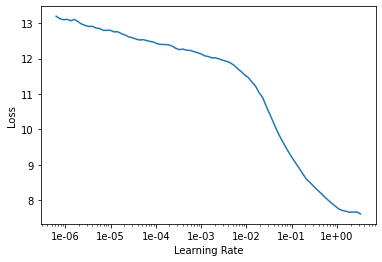

In [22]:
learn.recorder.plot()

In [ ]:
# I literally copied-paste this, for convenience, in case you wanna retrain with new lr.
learn = tabular_learner(data, layers=[1000,500], 
                        ps=[0.001,0.01], 
                        emb_drop=0.04, 
                        y_range=y_range, 
                        metrics=exp_rmspe) 

In [23]:
learn.fit_one_ cycle(1, 5e-2, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.019941,0.016738,0.131011,09:17


In [24]:
learn.save('1')

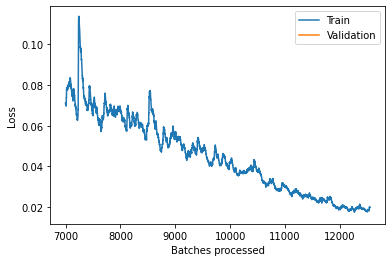

In [27]:
learn.recorder.plot_losses(skip_start=7000)

In [28]:
learn.load('1');

In [ ]:
learn.fit_one_cycle(5, 3e-4)

In [ ]:
learn.fit_one_cycle(5, 3e-4)

(10th place in the competition was 0.108)

In [ ]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)